# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Import User-defined functions:

### 1. The function below serves two purposes. The first one is to plot a trapezoid on the image to find the region in which the majority of lane lines. The second one is to identify the lane lines in this region using color threshold. 

* Note: Yellow color means no blue element. 

In [2]:
# Find the region and color threshold for the lanes to reduce nosie and processing time
# The region area is about the lower half of the image, and color threshold is set to [200,200,0], because yellow color 
#has no blue color and white is [255,255,255]. Combining them the threshold would work in good accuracy. 

def region_color_of_interest(image):
    ysize=image.shape[0]
    xsize=image.shape[1]
    #check x and y coordinates of the image
    color_select = np.copy(image)
    line_image = np.copy(image)
    #copy image to prevent mistakenly change the original image
    
    #define color selection threshold
    red=185
    green=185
    blue=0
    #for rgb, yellow has no blue color, this threshold is sufficient to screen out yellow and white lane lines
    rgb_threshold=[red,green,blue]
    
    #create the region of interest with 4 points
    
    left_bottom = [25,540]
    right_bottom = [920, 540]
    apex_l = [300, 350]
    apex_r = [600, 350]
    
    # Perform a linear fit (y=Ax+B) to each of the four sides of the region
    # np.polyfit returns the coefficients [A, B] of the fit
    #1 here means one degree of freedom(straight line), 2 or above mean curve
    fit_left = np.polyfit((left_bottom[0], apex_l[0]), (left_bottom[1], apex_l[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex_r[0]), (right_bottom[1], apex_r[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    fit_top = np.polyfit((apex_l[0], apex_r[0]), (apex_l[1], apex_r[1]), 1)
    
    #mask pixels below the threshold
    color_threshold = (image[:,:,0] < rgb_threshold[0])|(image[:,:,1] < rgb_threshold[1])|(image[:,:,2] < rgb_threshold[2])
    
    #find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))

    #because y=AX+B, any points in YY satisfy the conditions are in the region we desire
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1])) &\
                    (YY > (XX*fit_top[0] + fit_top[1]))
    #hide regions outside the desired area or the color that below the thresholds
    color_select[color_threshold|~region_thresholds] = [0,0,0]

    #highlight the lanes in the desired region
    line_image[~color_threshold & region_thresholds] = [250,0,0]
    #print(type(~color_threshold & region_thresholds))
    
    #f,axarr = plt.subplots(1,2,figsize=(15,15))
    #axarr[0].imshow(line_image)
    #axarr[0].plot(x,y,'b--', lw=4)

    #axarr[1].imshow(color_select)
    #axarr[1].plot(x,y,'r--', lw=4)
    return color_select

### 2. Gray the image and apply Canny Edge Detection and Hough Transform on the image

1. Apply Gaussian smooth to reduce the noise
2. Apply Canny Edge Dection to find out the edges of the lanes
3. Apply Hough Transform to find out the lines of the lanes

* Note: The difference in cv2.HoughLinesP() and cv2.HoughLines()

cv2.HoughLinesP() directly returns the two endpoints of the lines, while cv2.HoughLines() return the parameters of lines, where are slope and y-intercept, and the coordinates of two endpoints need to be found out. 

In [3]:
def gray_canny_hough_transfrom(image):
    #image = mpimg.imread('test_images/solidWhiteRight.jpg')
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    #blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 75
    high_threshold = 150
    #apply canny edge detection to the region of interest only
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
        
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 12 #minimum number of pixels making up a line
    max_line_gap = 3    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(edges, (x1, y1), (x2, y2), [250,0,0], 5)
    
    #print(lines)
    #plt.imshow(edges)
    return lines,color_edges

### 3. Connect the segments of lanes to a single one

The biggest issue in this function is the robustness. Sometimes the single line has the difficulty in representing the lane line; in other words, deviations between the plotted line and the lane line can be observed, especially in the condition that lane line marks are not clear in the image, for instance, in the challenge video. 

Several methods I can think of to improve the robustness of the solid line. 1, consider the average slope of the lane, because the slope for left or right lane line should be relatively consistent. When lane markers are not clearly detected, the previous slope is referred for the slope. 2. Using dynamic color threshold to better identify the lane color. 3. Using a smaller region that can include the lane line and exclude non-related area to reduce noise.  

In [4]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    
    left_bottom = [25,540]
    right_bottom = [920, 540]
    apex_l = [300, 350]
    apex_r = [600, 350]
    
    left_slope= []
    right_slope =[]
    left_points=[]
    right_points=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 < 450 and x1 >50:
                left_points.append((x1,y1))
            if x1 > 500 and x1 < 900:
                right_points.append((x1,y1))
            if x2 < 450 and x2 >50:
                left_points.append((x2,y2))
            if x2 > 500 and x2 < 900:
                right_points.append((x2,y2))
    left_points.sort()
    right_points.sort()
    #print(left_points)
    x_avg_l = (left_points[1][0] + left_points[len(left_points)-2][0])/2
    y_avg_l = (left_points[1][1] + left_points[len(left_points)-2][1])/2
    
    left_slope = (y_avg_l-left_points[1][1])/(x_avg_l - left_points[1][0])
        
    x_avg_r = right_points[1][0] + right_points[len(right_points)-2][0]
    y_avg_r = right_points[1][1] + right_points[len(right_points)-2][1]
    
    right_slope = (y_avg_r - right_points[1][1])/(x_avg_r - right_points[1][0])
    
    #print('left,right',left_slope,right_slope)

    #becaue right lane is more stable
    if (abs(left_slope)/right_slope) > 1.2:
        left_slope = -right_slope *1.2
    elif (abs(left_slope)/right_slope) < 0.85:
        left_slope = -right_slope *1.2
    left_bias = y_avg_l - left_slope*x_avg_l
    
    #print('y_avg_l,x_avg_l,left_bias', y_avg_l,x_avg_l,left_bias)
    right_bias = y_avg_r - right_slope*x_avg_r
    
    #find the equation(y=mx+b) of left lane (avearged) in the image,l_points(x,y) and slope(m) are known. y-intercetp(b)
    #can be found out.
    
    # initialize the points
    left_lane_top=[0,0]
    left_lane_bottom=[0,0]
   
    left_lane_top[0] = int((apex_l[1] - left_bias)/left_slope)
    left_lane_top[1] = apex_l[1]
    
    left_lane_bottom[0] = int((left_bottom[1] - left_bias)/left_slope)
    left_lane_bottom[1] = left_bottom[1]    
    
    cv2.line(img, (left_lane_top[0], left_lane_top[1]), (left_lane_bottom[0], left_lane_bottom[1]), color, thickness)

    
    right_lane_top=[0,0]
    right_lane_bottom=[0,0]
    
    right_lane_top[0] = int((apex_r[1] - right_bias)/right_slope)
    right_lane_top[1] = apex_r[1]
    
    right_lane_bottom[0] = int((right_bottom[1] - right_bias)/right_slope)
    right_lane_bottom[1] = right_bottom[1]    
    
    cv2.line(img, (right_lane_top[0], right_lane_top[1]), (right_lane_bottom[0], right_lane_bottom[1]), color, thickness)

### Process_image Function integrates all the previously defined functions together and generates image results

In [5]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image = cv2.resize(image,(960,540))
    #critical to make the codes working
    color_select=region_color_of_interest(image)
    lines, color_edges = gray_canny_hough_transfrom(color_select)
    draw_lines(image,lines)
    result = cv2.addWeighted(color_edges, 0.5, image, 1, 0)
    plt.imshow(result)
    return result

## Read in Test Images

This image1 is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


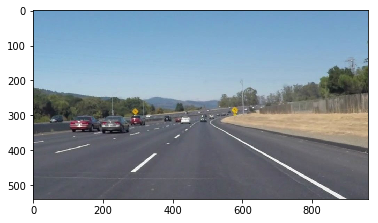

In [6]:
#reading in an image
image1 = mpimg.imread('test_images/solidWhiteCurve.jpg')
image1 = cv2.resize(image1,(960,540))
#printing out some stats and plotting
print('This image1 is:', type(image1), 'with dimensions:', image1.shape)
plt.imshow(image1) 
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

This image2 is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


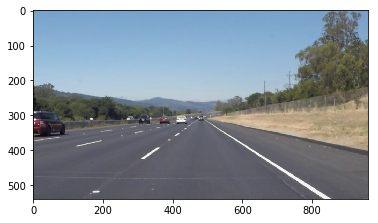

In [7]:
#reading in an image
image2 = mpimg.imread('test_images/solidWhiteRight.jpg')
image2 = cv2.resize(image2,(960,540))
#printing out some stats and plotting
print('This image2 is:', type(image2), 'with dimensions:', image2.shape)
plt.imshow(image2) 
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

This image3 is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


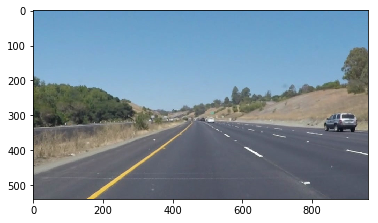

In [8]:
#reading in an image
image3 = mpimg.imread('test_images/solidYellowCurve.jpg')
image3 = cv2.resize(image3,(960,540))
#printing out some stats and plotting
print('This image3 is:', type(image3), 'with dimensions:', image3.shape)
plt.imshow(image3) 

This image4 is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


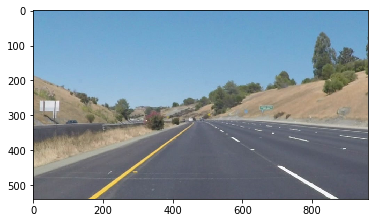

In [9]:
#reading in an image
image4 = mpimg.imread('test_images/solidYellowCurve2.jpg')
image4 = cv2.resize(image4,(960,540))
#printing out some stats and plotting
print('This image4 is:', type(image4), 'with dimensions:', image4.shape)
plt.imshow(image4) 
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

This image5 is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


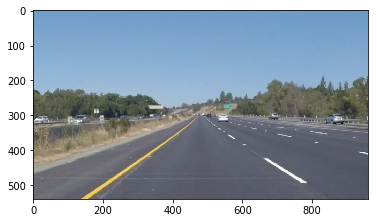

In [10]:
#reading in an image
image5 = mpimg.imread('test_images/solidYellowLeft.jpg')
image5 = cv2.resize(image5,(960,540))
#printing out some stats and plotting
print('This image5 is:', type(image5), 'with dimensions:', image5.shape)
plt.imshow(image5) 
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

This image6 is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


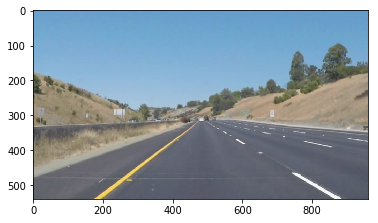

In [11]:
#reading in an image
image6 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image6 = cv2.resize(image6,(960,540))
#printing out some stats and plotting
print('This image6 is:', type(image6), 'with dimensions:', image6.shape)
plt.imshow(image6) 
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

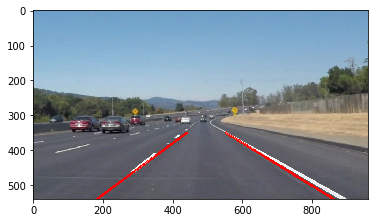

In [12]:
image1=process_image(image1)

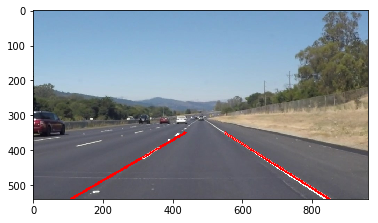

In [13]:
image2=process_image(image2)

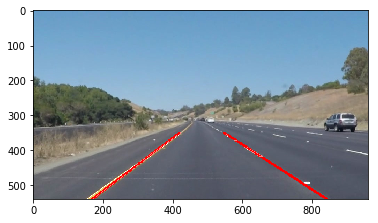

In [14]:
image3=process_image(image3)

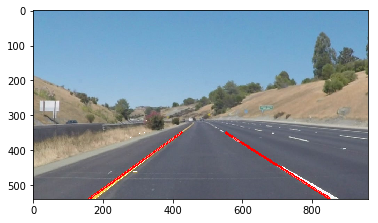

In [15]:
image4=process_image(image4)

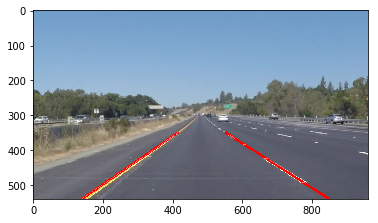

In [16]:
image5=process_image(image5)

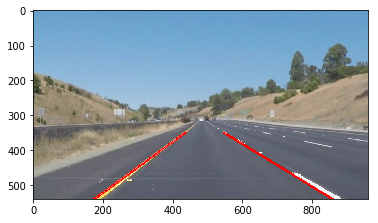

In [17]:
image6=process_image(image6)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [18]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:17<00:00, 12.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



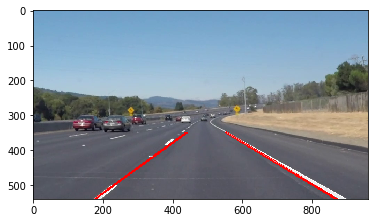

In [21]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#white_clip = clip1.fl_image(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB))

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:53<00:00, 12.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 



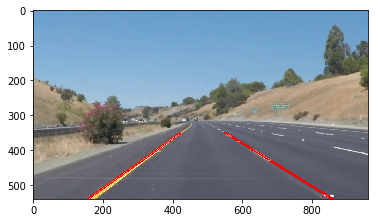

In [23]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_clip.write_videofile(yellow_output, audio=False)

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 55%|███████████████████████████████████████████▋                                    | 137/251 [00:12<00:10, 11.06it/s]

IndexError: list index out of range

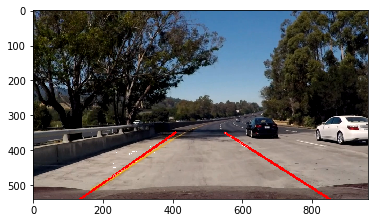

In [25]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

* NOTE: THE FOLLOWING FUNCTIONS ARE NOT USED. PLACEHOLDER!

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# Iterate over the output "lines" and draw lines on a blank image
#for line in lines:
#    for x1,y1,x2,y2 in line:
#        slope.append((y2-y1)/(x2-x1))
#        cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),5)
#slope.sort()
#print(slope)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [ ]:
# this function is NOT used in the program

def draw_lines_1(img, lines, color=[255, 0, 0], thickness=5):
    
    left_bottom = [25,540]
    right_bottom = [920, 540]
    apex_l = [300, 350]
    apex_r = [600, 350]
    
    left_slope= []
    right_slope =[]
    left_points=[]
    right_points=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(x2-x1) <= 0.1:
                continue
            i=(y2-y1)/(x2-x1)
            if abs(i)<=0.2 or abs(i)>2:
                continue
            if i<0:
                left_slope.append(i)
                left_points.append((x1,y1))
                left_points.append((x2,y2))
            else:
                right_slope.append(i)
                right_points.append((x1,y1))
                right_points.append((x2,y2))
    
    left_points.sort()
    right_points.sort()
    
    
    # To prevent left and right lanes crossing
    l_points = []
    for i in range(len(left_points)):
        if left_points[i][0] < 450 and left_points[i][0]>50:
            l_points.append(left_points[i])
        else:
            continue
    left_points = l_points
    #print('left_points',left_points)
    #find the minimum and maxium points on the left lane to its y=Ax+B equation accurately 
    most_left_left_x=left_points[0][0] 
    most_left_left_y=left_points[0][1]
    
    most_left_right_x=left_points[len(left_points)-1][0]
    most_left_right_y=left_points[len(left_points)-1][1]

    slope_left=(most_left_right_y - most_left_left_y)/(most_left_right_x - most_left_left_x)
    
    # Y-intercept for the left lane in the context of the coordinates of the image:
    #print('slope_left', slope_left)
    left_intercept = most_left_left_y - slope_left*most_left_left_x
    #print('left_intercept', left_intercept)

    
    #find the equation(y=mx+b) of left lane (avearged) in the image,l_points(x,y) and slope(m) are known. y-intercetp(b)
    #can be found out.
    
    #left_intercept=l_points[1]-slope[0]*l_points[0]
    
    left_lane_top=[0,0]
    left_lane_bottom=[0,0]
    #print(l_points[1])
    left_lane_top[0] = int((apex_l[1] - left_intercept)/slope_left)
    left_lane_top[1] = apex_l[1]
    
    left_lane_bottom[0] = int((left_bottom[1] - left_intercept)/slope_left)
    left_lane_bottom[1] = left_bottom[1]    
    
    cv2.line(img, (left_lane_top[0], left_lane_top[1]), (left_lane_bottom[0], left_lane_bottom[1]), color, thickness)
       
    #find the minimum and maxium points on the right lane to its y=Ax+B equation accurately 
    
    r_points = []
    for i in range(len(right_points)):
        if right_points[i][0]>most_left_right_x:
            r_points.append(right_points[i])
        else:
            continue
    #print('r_points',r_points)
    right_points = r_points
    #print('right_points',right_points)
    if len(right_points) <= 1:
        most_right_left_x = most_left_left_x + 100
        most_right_left_y = most_left_left_y
        most_right_right_x = most_left_right_x + 450
        most_right_right_y = most_left_right_y
    else:
        most_right_left_x=right_points[0][0] 
        most_right_left_y=right_points[0][1]
        most_right_right_x=right_points[len(right_points)-1][0]
        most_right_right_y=right_points[len(right_points)-1][1]
    
    slope_right=(most_right_right_y - most_right_left_y)/(most_right_right_x - most_right_left_x)
    #print('slope_right', slope_right)
    # Y-intercept for the left lane in the context of the coordinates of the image:
    
    right_intercept = most_right_left_y - slope_right*most_right_left_x
    #print('right_intercept', right_intercept)
    
    #right_intercept=r_points[1]-slope[1]*r_points[0]
    
    right_lane_top=[0,0]
    right_lane_bottom=[0,0]
    #print(r_points[1])
    right_lane_top[0] = int((apex_r[1] - right_intercept)/slope_right)
    right_lane_top[1] = apex_r[1]
    
    right_lane_bottom[0] = int((right_bottom[1] - right_intercept)/slope_right)
    right_lane_bottom[1] = right_bottom[1]    
    
    cv2.line(img, (right_lane_top[0], right_lane_top[1]), (right_lane_bottom[0], right_lane_bottom[1]), color, thickness)